In [1]:
import scipy.io
import scipy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale
from tensorflow.keras.utils import plot_model

In [2]:
from comsolml import read_data
from comsolml.filter import butter_lowpass_filter
from comsolml.custom_fk import tx_fk_plot, make_fk
from comsolml.custom_ml import make_regression_model, make_autoencoder, do_regression, plot_reg_results
from comsolml.vel_estim import FK_thickness_estimation, make_lamb_curves

In [3]:
sns.set_style('whitegrid')
sns.set_context('paper')

In [4]:
timesamples = 400
noisedb = -18
dt = 1e-6
numsensors = 8
circ = 3455*0.2e-3
encoding_dim = 64

In [5]:
def make_dx(decim):
    dx = circ/numsensors*decim
    return dx

def make_dtheta(decim):
    dtheta = 2*np.pi/numsensors*decim
    return dtheta

def conv_m_to_rad(meters, circumference):
    theta = 2*np.pi*meters/circumference
    return theta

In [6]:
make_dtheta(1)

0.7853981633974483

In [7]:
read_data

<module 'comsolml.read_data' from 'c:\\Users\\Magnus\\PycharmProjects\\PhD\\Comsol_ML\\notebooks\\comsolml\\read_data.py'>

# COMSOL Data

In [8]:
#filename_synth = Path().joinpath('..', 'data', 'input_synth', 'concat_traces_systematic_f80_145_avg79.mat')
#X = read_data.read_synth(filename_synth, 'concat_traces', 9, 18, geom_spread=False)

In [9]:

filename_synth_s = Path().joinpath('..', 'data', 'input_synth', 'concat_traces_systematic_f80_145_avg79.mat')
X_s = read_data.read_synth(filename_synth_s, 'concat_traces', 9, 18, geom_spread=False, mat_73=False)
#X_s = read_data.read_synth(filename_synth_s, 'concat_traces', 6, 12, geom_spread=False, mat_73=False)
filename_synth_r = Path().joinpath('..', 'data', 'input_synth', 'concat_traces_random_f80_145_avg79.mat')
X_r = read_data.read_synth(filename_synth_r, 'concat_traces', 9, 18, geom_spread=False, mat_73=True)
#X_r = read_data.read_synth(filename_synth_r, 'concat_traces', 6, 12, geom_spread=False, mat_73=True)

In [10]:
X = np.concatenate((X_s, X_r))

In [11]:
X.shape

(9383, 8, 401)

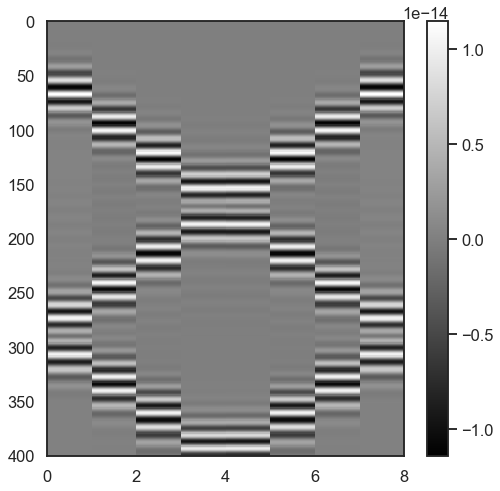

In [12]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(8,8))

plt.pcolormesh(X[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()

In [13]:
X.max(), X.min()

(2.3089463e-14, -2.2737519e-14)

In [14]:
X.shape[2]

401

In [15]:
random_scale = np.expand_dims(np.random.normal(loc=1.0, scale=0.4, size=X.shape[:2]), axis=2)

In [16]:
random_scale.shape

(9383, 8, 1)

In [17]:
X_rand = np.multiply(X, random_scale)

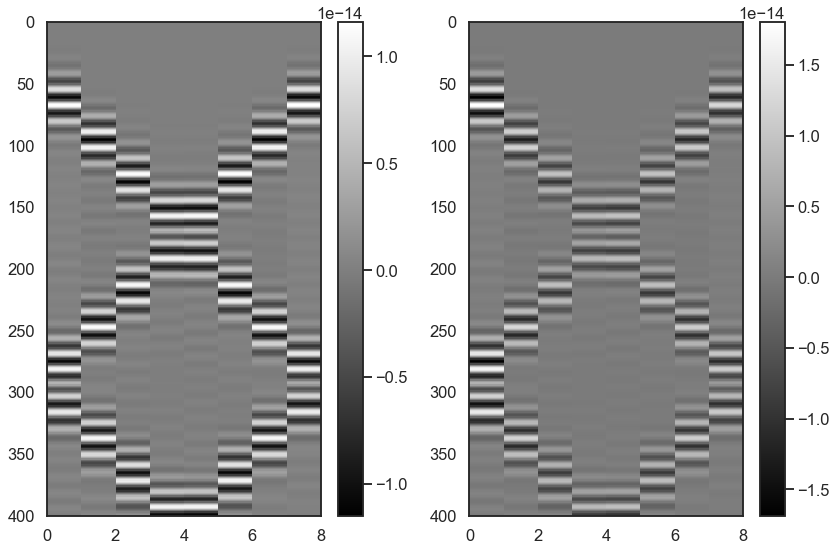

In [18]:
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.pcolormesh(X[1,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(122)

plt.pcolormesh(X_rand[1,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()

plt.tight_layout()
plt.show()

In [19]:
X = X_rand

In [20]:
labels_s = pd.read_csv(Path().joinpath('..', 'data', 'input_synth', 'labels_systematic_f80_145_avg79.csv'))
labels_r = pd.read_csv(Path().joinpath('..', 'data', 'input_synth', 'labels_random_f80_145_avg79.csv'))

In [21]:
labels = pd.concat((labels_s, labels_r))

In [22]:
labels.rename(columns={'thickness':'Thickness',
                       'depression':'Depression depth',
                       'pitting':'Pitting depth',
                       'depression_mu':'Depression location',
                       'depression_sigma':'Depression width',
                       'thickness_max':'Thickness maximum',
                       'thickness_min':'Thickness minimum',
                       'thickness_mean':'Thickness mean',
                       'thickness_median':'Thickness median',
                       'thickness_std':'Thickness std'}, inplace=True)

In [23]:
labels

,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var,model_rough_coeff,num_pits
0,model_s101_t032_d000_p000,6.4,101,0.0,0.0,351.267366,55.653407,6.4,6.4,6.400000,6.4,0.000000,0.000000,1.000000,0
1,model_s101_t032_d000_p002,6.4,101,0.0,0.4,351.267366,55.653407,6.4,6.0,6.209375,6.2,0.145174,0.021076,1.269029,0
2,model_s101_t032_d000_p004,6.4,101,0.0,0.8,351.267366,55.653407,6.4,5.6,6.087269,6.2,0.230522,0.053140,1.307393,191
3,model_s101_t032_d000_p006,6.4,101,0.0,1.2,351.267366,55.653407,6.4,5.2,6.027662,6.0,0.291548,0.085000,1.317464,78
4,model_s101_t032_d000_p008,6.4,101,0.0,1.6,351.267366,55.653407,6.4,4.8,6.005903,6.0,0.324993,0.105621,1.319622,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6037,model_c3456_t050_d023_p009_r998_s1701898195,10.0,1701898195,4.6,1.8,419.313938,23.777331,10.0,5.4,9.559664,10.0,1.084208,1.175507,1.026493,10
6038,model_c3456_t050_d023_p010_r809_s1561625081,10.0,1561625081,4.6,2.0,215.409010,29.107722,10.0,4.8,9.436806,10.0,1.177173,1.385736,1.156334,3
6039,model_c3456_t050_d023_p013_r839_s1610765892,10.0,1610765892,4.6,2.6,184.917121,70.649192,10.0,4.0,8.729167,9.6,1.640418,2.690970,1.145304,5
6040,model_c3456_t050_d024_p003_r960_s1545540344,10.0,1545540344,4.8,0.6,333.771042,83.929996,10.0,4.8,8.528472,9.4,1.691432,2.860943,1.049634,6


In [24]:
'''
sns.set_style('white')
sns.set_context('talk')
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pcolormesh(X_sample_c[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(X_sample_n[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.colorbar()


plt.show()
'''

"\nsns.set_style('white')\nsns.set_context('talk')\nplt.figure(figsize=(12,8))\nplt.subplot(1,2,1)\nplt.pcolormesh(X_sample_c[0,:,:].T, cmap='gray')\nplt.gca().invert_yaxis()\nplt.colorbar()\nplt.subplot(1,2,2)\nplt.pcolormesh(X_sample_n[0,:,:].T, cmap='gray')\nplt.gca().invert_yaxis()\nplt.colorbar()\n\n\nplt.show()\n"

# Verasonics Data

In [25]:
#pathname_data = Path().joinpath('..','data', 'input_real', 'Verasonics_data', 'magnus_2023_03_09', 'data')
#pathname_data = Path().joinpath('..','data', 'input_real', 'Verasonics_data', 'magnus_2023_03_14', 'data')
#pathname_data = Path().joinpath('..','data', 'input_real', 'Verasonics_data', 'magnus_2023_09_13', 'data')
#pathname_data = Path().joinpath('..','data', 'input_real', 'Verasonics_data', 'magnus_2023_09_26', 'data')
#pathname_data = Path().joinpath('..','data', 'input_real', 'Verasonics_data', 'magnus_2023_09_28', 'data') # Best?
#pathname_data = Path().joinpath('..','data', 'input_real', 'Verasonics_data', 'magnus_2023_10_02', 'data')
pathname_data = Path().joinpath('..','data', 'input_real', 'Verasonics_data', 'magnus_2023_10_18', 'data')


In [26]:
#filename_data = Path().joinpath(pathname_data, '060kHz_8ch_s1_inputfilterfix_2023-03-03_15_15_55.mat')
#filename_data = Path().joinpath(pathname_data, '060kHz_8ch_s1_inputfilterfix_2023-03-09_15_57_15.mat')

#filename_data = Path().joinpath(pathname_data, '060kHz_8ch_s1_2023-03-14_13_22_20.mat') #strap off
#filename_data = Path().joinpath(pathname_data, '060kHz_8ch_s1_2023-03-14_13_26_56.mat') #strap on
#filename_data = Path().joinpath(pathname_data, '080kHz_8ch_s1_2023-03-14_13_30_15.mat')
#filename_data = Path().joinpath(pathname_data, '100kHz_8ch_s1_2023-03-14_13_31_21.mat')
#filename_data = Path().joinpath(pathname_data, '120kHz_8ch_s1_2023-03-14_13_32_29.mat')
#filename_data = Path().joinpath(pathname_data, "080kHz_8ch_s1_2023-09-13_13_41_51.mat")

#filename_data = Path().joinpath(pathname_data, "078kHz_8ch_s1_2023-09-13_13_41_20.mat")

#filename_data = Path().joinpath(pathname_data, "070kHz_8ch_s1_2023-09-13_13_39_07.mat")
#filename_data = Path().joinpath(pathname_data, "080kHz_8ch_s1_2023-09-26_12_54_45.mat")

#filename_data = Path().joinpath(pathname_data, "080kHz_8ch_s1_2023-09-28_12_49_00.mat") #Best?
#filename_data = Path().joinpath(pathname_data, "080kHz_8ch_s1_2023-10-02_13_01_05.mat")
filename_data = Path().joinpath(pathname_data, "080kHz_8ch_s1_2023-10-18_10_27_57.mat")


In [27]:
mat = scipy.io.loadmat(filename_data)

In [28]:
meta = mat['meta']
t_array = meta['FTaxis'][0,0]
data = mat['RFdata']

In [29]:
data = data[:,1:,:] #Remove source trace

In [30]:
np.diff(t_array).mean()/1e-6

0.8

Sample rate is 0.8 microseconds (1.25Mhz)

In [31]:
native_dt = 0.8e-6

In [32]:
1/native_dt

1250000.0

In [33]:
data_stack = np.sum(data, axis=2)

In [34]:
def remove_dc(data):
    return data - data.mean(axis=0, keepdims=True)

In [35]:
data_stack_dc_removed = remove_dc(data_stack)

In [36]:
def compute_rms(trace):
    squared = np.float64(np.square(trace))
    mean = np.sum(squared)/len(trace)
    rms = np.sqrt(mean)
    return rms

In [37]:
def compute_rms_values(data):
    rms_values = []
    trace_nums = np.arange(0, data.shape[1])
    for trace_num in trace_nums:
        rms_values.append(compute_rms(data[:,trace_num]))
    return rms_values

In [38]:
rms_values = compute_rms_values(data_stack_dc_removed[:,:])

In [39]:
scaling_factors = [1/x for x in rms_values]

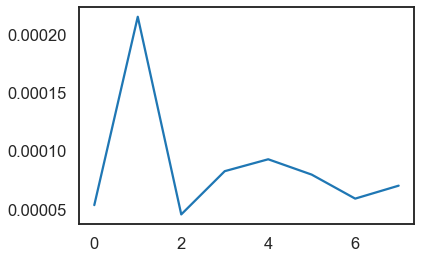

In [40]:
plt.plot(scaling_factors)

In [41]:
data_stack_scaled = np.zeros(shape=data_stack_dc_removed.shape)
for trace_num, scaling_factor in enumerate(scaling_factors):
    data_stack_scaled[:,trace_num] = scaling_factor*data_stack_dc_removed[:,trace_num]

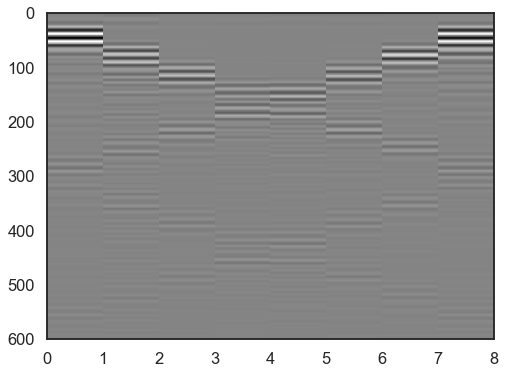

In [42]:
plt.figure(figsize=(8,6))
plt.pcolormesh(data_stack_scaled[:600,:], cmap='gray')
plt.gca().invert_yaxis()
plt.show()

In [43]:
#data_stack_scaled.shape, X_sample_n.shape

In [44]:
# Crop and Resample
data_stack_scaled_resamp = scipy.signal.resample(data_stack_scaled[:600,:], 480).T

In [45]:
data_stack_scaled_resamp.shape

(8, 480)

In [46]:
data_stack_scaled_resamp = data_stack_scaled_resamp/data_stack_scaled_resamp.max()

In [47]:
data_stack_scaled_resamp.min()

-1.0578978748895538

In [48]:
labels[(labels['Thickness'] == 6.8)]

,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var,model_rough_coeff,num_pits
42,model_s101_t034_d000_p000,6.8,101,0.0,0.0,351.267366,55.653407,6.8,6.8,6.800000,6.8,0.000000,0.000000,1.000000,0
43,model_s101_t034_d000_p002,6.8,101,0.0,0.4,351.267366,55.653407,6.8,6.4,6.603877,6.6,0.145226,0.021091,1.271427,0
44,model_s101_t034_d000_p004,6.8,101,0.0,0.8,351.267366,55.653407,6.8,6.0,6.469792,6.4,0.234485,0.054983,1.314587,228
45,model_s101_t034_d000_p006,6.8,101,0.0,1.2,351.267366,55.653407,6.8,5.6,6.414352,6.4,0.289402,0.083753,1.322979,85
46,model_s101_t034_d000_p008,6.8,101,0.0,1.6,351.267366,55.653407,6.8,5.2,6.399595,6.4,0.310864,0.096637,1.324897,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,model_c3456_t034_d023_p001_r070_s1720746496,6.8,1720746496,4.6,0.2,452.471917,62.164359,6.4,1.4,5.017593,6.0,1.525157,2.326104,1.165206,8
1390,model_c3456_t034_d023_p007_r627_s1727734027,6.8,1727734027,4.6,1.4,338.514252,83.420493,6.8,1.0,5.202199,6.0,1.637589,2.681697,1.277539,5
1391,model_c3456_t034_d023_p009_r960_s1612860553,6.8,1612860553,4.6,1.8,438.610731,64.923237,6.8,0.8,5.670312,6.6,1.571158,2.468537,1.055746,9
1392,model_c3456_t034_d023_p013_r881_s1617975390,6.8,1617975390,4.6,2.6,270.568774,16.411050,6.8,0.2,6.401620,6.8,1.025768,1.052200,1.126960,10


In [49]:
from acoustics import generator
def make_noise(noisedb, noiseshape, color='whitenormal'):
  noiselev = 10**(noisedb/10)
  if color=='whitenormal':
    noise = np.random.normal(loc=0, scale=1, size=noiseshape)*noiselev
  else:
    noise = np.zeros(noiseshape, dtype='float32')
    for i in range(noiseshape[0]):
      for j in range(noiseshape[1]):
        noise[i, j, :] = generator.noise(noiseshape[2], color='white')*noiselev
  return noise

In [50]:
X.max()

3.630946601186271e-14

In [51]:
#X_crop = X[:,:,26:]

In [52]:
#time_scaling = np.cbrt(np.arange(1, X.shape[-1]+1, dtype='float32'))
time_scaling = np.sqrt(np.arange(1, X.shape[-1]+1, dtype='float32'))
time_scaling = np.expand_dims(time_scaling, -1).T
time_scaling.shape

(1, 401)

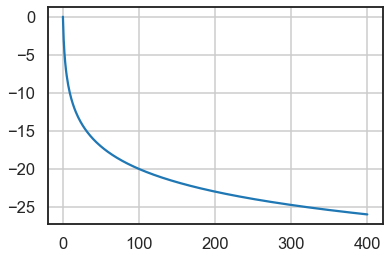

In [53]:
plt.plot(20*np.log10(1/time_scaling[0]))
plt.grid()
plt.show()

In [54]:
X.shape

(9383, 8, 401)

In [55]:
X_geom = np.divide(X, time_scaling**3)

In [56]:
X_sample_c = X_geom/X_geom.max()

In [57]:
X_sample_n = X_sample_c + make_noise(noisedb, X_sample_c.shape)

In [58]:
X_sample_n.max()

1.0104175281751797

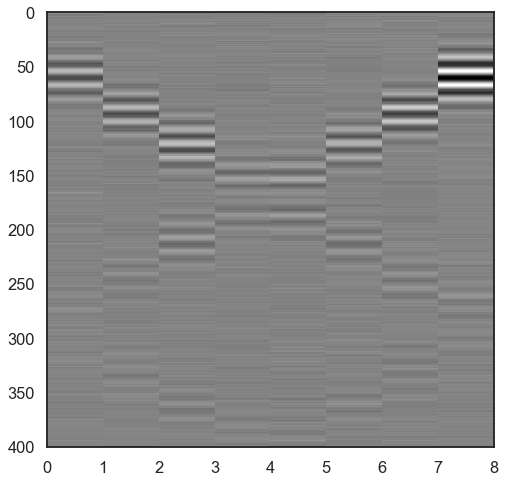

In [59]:
plt.figure(figsize=(8,8))
plt.pcolormesh(X_sample_n[0,:,:].T, cmap='gray')
plt.gca().invert_yaxis()

## Low-pass filter

In [60]:
help(scipy.signal.butter)

Help on function butter in module scipy.signal._filter_design:

butter(N, Wn, btype='low', analog=False, output='ba', fs=None)
    Butterworth digital and analog filter design.
    
    Design an Nth-order digital or analog Butterworth filter and return
    the filter coefficients.
    
    Parameters
    ----------
    N : int
        The order of the filter.
    Wn : array_like
        The critical frequency or frequencies. For lowpass and highpass
        filters, Wn is a scalar; for bandpass and bandstop filters,
        Wn is a length-2 sequence.
    
        For a Butterworth filter, this is the point at which the gain
        drops to 1/sqrt(2) that of the passband (the "-3 dB point").
    
        For digital filters, if `fs` is not specified, `Wn` units are
        normalized from 0 to 1, where 1 is the Nyquist frequency (`Wn` is
        thus in half cycles / sample and defined as 2*critical frequencies
        / `fs`). If `fs` is specified, `Wn` is in the same units as `fs`.


In [61]:
b, a = scipy.signal.butter(4, 85e3, fs=1e6)

C:\Users\Magnus\AppData\Local\Temp\ipykernel_21744\640816349.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(20*np.log10(np.abs(np.fft.rfft(imp_ff))))


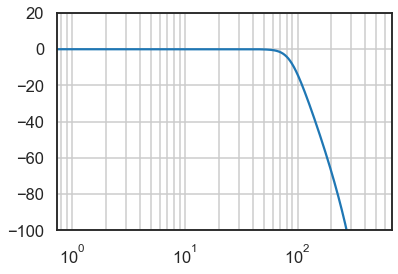

In [62]:
impulse = np.zeros(1000)
impulse[500] = 1
imp_ff = scipy.signal.filtfilt(b, a, impulse)
plt.semilogx(20*np.log10(np.abs(np.fft.rfft(imp_ff))))
plt.grid('True', which='both')
plt.ylim(-100, 20);

In [63]:
sig_ff = scipy.signal.filtfilt(b, a, data_stack_scaled_resamp, axis=1)

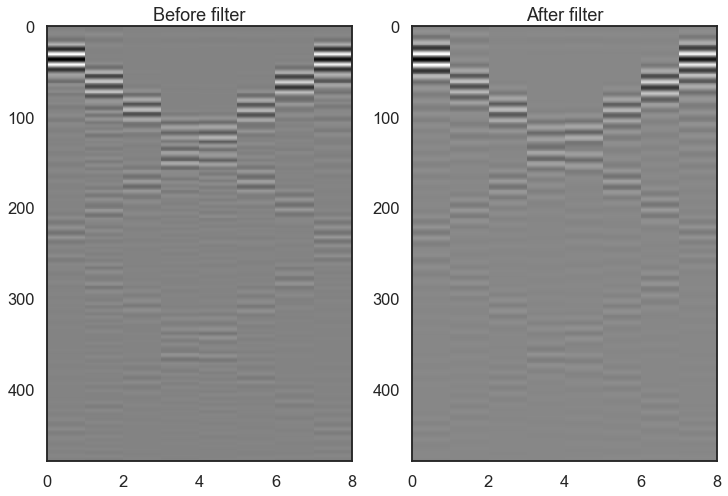

In [64]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.pcolormesh(data_stack_scaled_resamp[:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.title('Before filter')
plt.subplot(122)
plt.pcolormesh(sig_ff[:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.title('After filter');

In [65]:
data_stack_scaled_resamp = sig_ff

In [66]:
data_stack_scaled_resamp = data_stack_scaled_resamp/data_stack_scaled_resamp.max()

In [67]:
data_stack_scaled_resamp_n = data_stack_scaled_resamp + make_noise(noisedb, data_stack_scaled_resamp.shape)

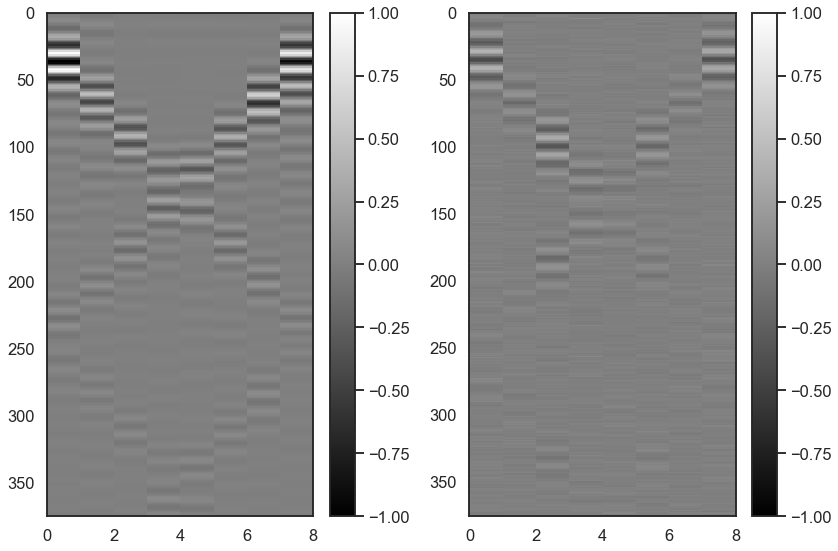

In [68]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.pcolormesh(data_stack_scaled_resamp[:,:375].T, cmap='gray')
plt.gca().invert_yaxis()
plt.clim(-1, 1)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(X_sample_n[42,:,25:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.clim(-1,1)
plt.colorbar()
plt.tight_layout()

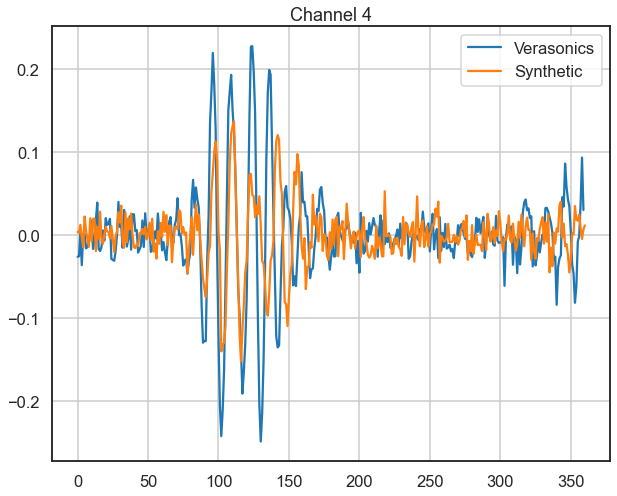

In [69]:
sns.set_context('talk')
plt.figure(figsize=(10,8))
plt.plot(data_stack_scaled_resamp_n[3,15:375], label='Verasonics')
plt.plot(X_sample_n[42,3,40:], label='Synthetic')
plt.legend()
plt.title('Channel 4')
plt.grid()
plt.show()

In [70]:
X_sample_c[:,:,41:].shape
X_sample_c_crop = X_sample_c[:,:,41:]

In [71]:
X_sample_n_crop = X_sample_n[:,:,41:]

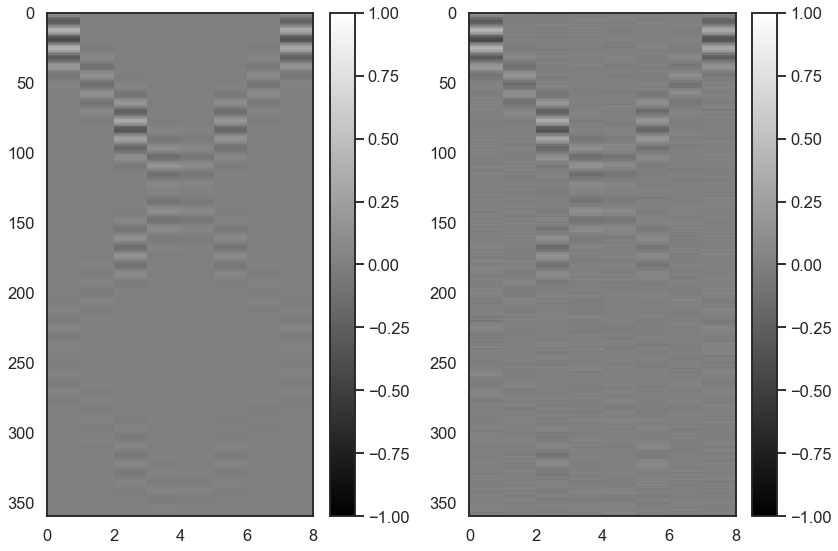

In [72]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.pcolormesh(X_sample_c_crop[42,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.clim(-1, 1)
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(X_sample_n_crop[42,:,:].T, cmap='gray')
plt.gca().invert_yaxis()
plt.clim(-1,1)
plt.colorbar()
plt.tight_layout()

In [73]:
verasonics_data = data_stack_scaled_resamp_n[:,15:375]

In [74]:
verasonics_data.shape, X_sample_n_crop.shape

((8, 360), (9383, 8, 360))

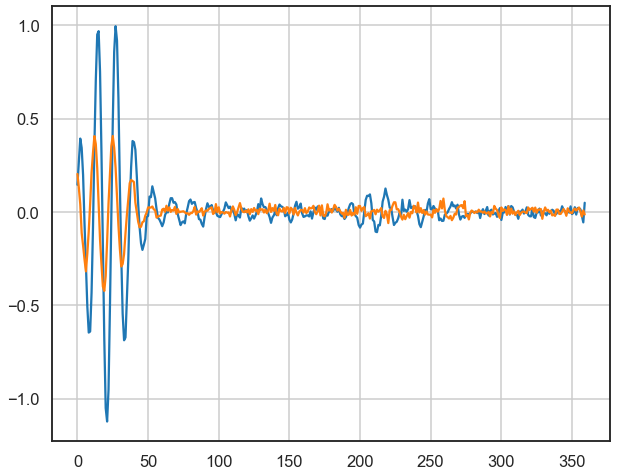

In [75]:
plt.figure(figsize=(10,8))
plt.plot(verasonics_data[0,:])
plt.plot(X_sample_n_crop[42,0,:])
plt.grid()
plt.show()

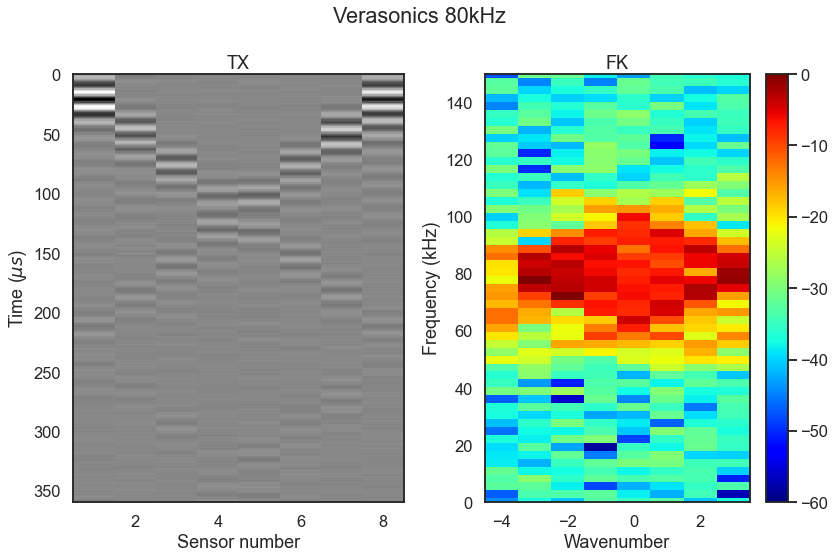

In [76]:
tx_fk_plot(verasonics_data.T, dt, make_dtheta(1), title='Verasonics 80kHz')

In [77]:
verasonics_data.shape

(8, 360)

In [78]:
#verasonics_data_manip = np.concatenate((verasonics_data[:-4], np.flip(verasonics_data[:-4], axis=0)))

In [79]:
#plt.figure(figsize=(6, 10))
#plt.pcolormesh(verasonics_data_manip.T, cmap='gray')
#plt.gca().invert_yaxis()
#plt.show()


In [80]:
#verasonics_data_manip = verasonics_data_manip + make_noise(noisedb, verasonics_data_manip.shape)

In [81]:

#tx_fk_plot(verasonics_data_manip.T, dt, make_dtheta(1), title='Verasonics 80kHz manipulated')

In [82]:
#verasonics_data = verasonics_data_manip ##### Cheating!!!! #####

In [83]:
X_sample_n_crop.shape

(9383, 8, 360)

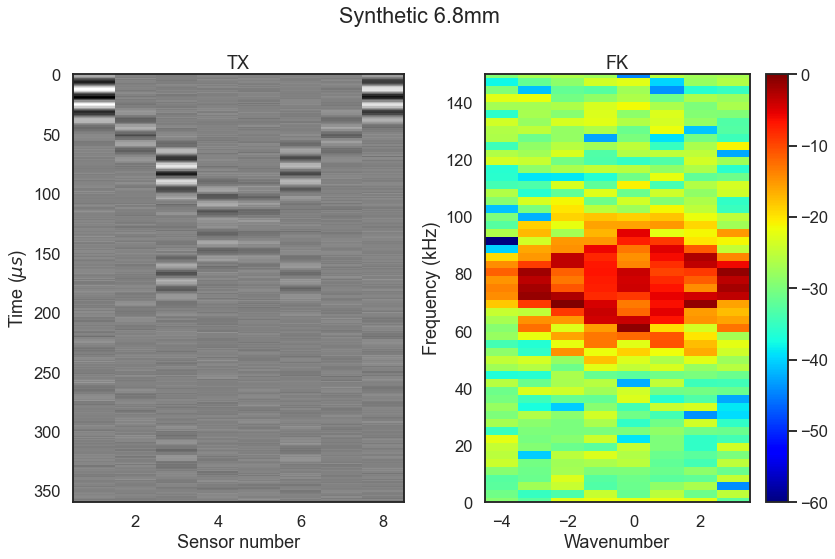

In [84]:
tx_fk_plot(X_sample_n_crop[42,:,:].T, dt, make_dtheta(1), title='Synthetic 6.8mm', log=True)

# Conventinal Thickness Estimation

In [85]:
steel = make_lamb_curves()


Calculating symmetric modes..

0/100 - 0.0 kHz × mm
1/100 - 101.0 kHz × mm
2/100 - 202.0 kHz × mm
3/100 - 303.0 kHz × mm
4/100 - 404.0 kHz × mm
5/100 - 505.1 kHz × mm
6/100 - 606.1 kHz × mm
7/100 - 707.1 kHz × mm
8/100 - 808.1 kHz × mm
9/100 - 909.1 kHz × mm
10/100 - 1010.1 kHz × mm
11/100 - 1111.1 kHz × mm
12/100 - 1212.1 kHz × mm
13/100 - 1313.1 kHz × mm
14/100 - 1414.1 kHz × mm
15/100 - 1515.2 kHz × mm
16/100 - 1616.2 kHz × mm
17/100 - 1717.2 kHz × mm
18/100 - 1818.2 kHz × mm
19/100 - 1919.2 kHz × mm


c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:227: RuntimeWarning: invalid value encountered in double_scalars
  k = omega/vp
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:229: RuntimeWarning: invalid value encountered in sqrt
  p = np.sqrt((omega/self.c_L)**2 - k**2, dtype=np.complex128)
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:230: RuntimeWarning: invalid value encountered in sqrt
  q = np.sqrt((omega/self.c_S)**2 - k**2, dtype=np.complex128)
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:256: RuntimeWarning: invalid value encountered in cdouble_scalars
  symmetric = (np.tan(q*self.h)/q
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:257: RuntimeWarning: invalid value encountered in cdouble_scalars
  + (4*(k**2)*p*np.tan(p*self.h))/(q**2 - k**2)**2)
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.p

20/100 - 2020.2 kHz × mm
21/100 - 2121.2 kHz × mm
22/100 - 2222.2 kHz × mm
23/100 - 2323.2 kHz × mm
24/100 - 2424.2 kHz × mm
25/100 - 2525.3 kHz × mm
26/100 - 2626.3 kHz × mm
27/100 - 2727.3 kHz × mm
28/100 - 2828.3 kHz × mm
29/100 - 2929.3 kHz × mm
30/100 - 3030.3 kHz × mm
31/100 - 3131.3 kHz × mm
32/100 - 3232.3 kHz × mm
33/100 - 3333.3 kHz × mm
34/100 - 3434.3 kHz × mm
35/100 - 3535.4 kHz × mm
36/100 - 3636.4 kHz × mm
37/100 - 3737.4 kHz × mm
38/100 - 3838.4 kHz × mm
39/100 - 3939.4 kHz × mm
40/100 - 4040.4 kHz × mm
41/100 - 4141.4 kHz × mm
42/100 - 4242.4 kHz × mm
43/100 - 4343.4 kHz × mm
44/100 - 4444.4 kHz × mm
45/100 - 4545.5 kHz × mm
46/100 - 4646.5 kHz × mm
47/100 - 4747.5 kHz × mm
48/100 - 4848.5 kHz × mm
49/100 - 4949.5 kHz × mm
50/100 - 5050.5 kHz × mm
51/100 - 5151.5 kHz × mm
52/100 - 5252.5 kHz × mm
53/100 - 5353.5 kHz × mm
54/100 - 5454.5 kHz × mm
55/100 - 5555.6 kHz × mm
56/100 - 5656.6 kHz × mm
57/100 - 5757.6 kHz × mm
58/100 - 5858.6 kHz × mm
59/100 - 5959.6 kHz × mm


c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:284: RuntimeWarning: invalid value encountered in cdouble_scalars
  + (((q**2 - k**2)**2)*np.tan(p*self.h))/(4*(k**2)*p))
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:283: RuntimeWarning: invalid value encountered in cdouble_scalars
  antisymmetric = (q * np.tan(q*self.h)
c:\Users\Magnus\PycharmProjects\PhD\Comsol_ML\notebooks\comsolml\lamb\lamb.py:284: RuntimeWarning: invalid value encountered in multiply
  + (((q**2 - k**2)**2)*np.tan(p*self.h))/(4*(k**2)*p))


13/100 - 1313.1 kHz × mm
14/100 - 1414.1 kHz × mm
15/100 - 1515.2 kHz × mm
16/100 - 1616.2 kHz × mm
17/100 - 1717.2 kHz × mm
18/100 - 1818.2 kHz × mm
19/100 - 1919.2 kHz × mm
20/100 - 2020.2 kHz × mm
21/100 - 2121.2 kHz × mm
22/100 - 2222.2 kHz × mm
23/100 - 2323.2 kHz × mm
24/100 - 2424.2 kHz × mm
25/100 - 2525.3 kHz × mm
26/100 - 2626.3 kHz × mm
27/100 - 2727.3 kHz × mm
28/100 - 2828.3 kHz × mm
29/100 - 2929.3 kHz × mm
30/100 - 3030.3 kHz × mm
31/100 - 3131.3 kHz × mm
32/100 - 3232.3 kHz × mm
33/100 - 3333.3 kHz × mm
34/100 - 3434.3 kHz × mm
35/100 - 3535.4 kHz × mm
36/100 - 3636.4 kHz × mm
37/100 - 3737.4 kHz × mm
38/100 - 3838.4 kHz × mm
39/100 - 3939.4 kHz × mm
40/100 - 4040.4 kHz × mm
41/100 - 4141.4 kHz × mm
42/100 - 4242.4 kHz × mm
43/100 - 4343.4 kHz × mm
44/100 - 4444.4 kHz × mm
45/100 - 4545.5 kHz × mm
46/100 - 4646.5 kHz × mm
47/100 - 4747.5 kHz × mm
48/100 - 4848.5 kHz × mm
49/100 - 4949.5 kHz × mm
50/100 - 5050.5 kHz × mm
51/100 - 5151.5 kHz × mm
52/100 - 5252.5 kHz × mm


In [86]:
help(steel)

Help on Lamb in module comsolml.lamb.lamb object:

class Lamb(builtins.object)
 |  Lamb(thickness, nmodes_sym, nmodes_antisym, fd_max, vp_max, c_L, c_S, c_R=None, fd_points=100, vp_step=100, material='')
 |  
 |  A class used to calculate and plot Lamb wave dispersion curves 
 |  for traction-free, homogeneous and isotropic plates. It also allows 
 |  to generate an animation of the displacement vector field.
 |  
 |  Methods
 |  -------
 |  plot_phase_velocity(modes, cutoff_frequencies, material_velocities,
 |                      save_img, sym_style, antisym_style):
 |      Plot phase velocity as a function of frequency × thickness.
 |  plot_group_velocity(modes, cutoff_frequencies, save_img, sym_style,
 |                      antisym_style):
 |      Plot group velocity as a function of frequency × thickness.
 |  plot_wave_number(modes, save_img, sym_style, antisym_style):
 |      Plot wavenumber as a function of frequency × thickness.
 |  plot_wave_structure(mode, nrows, ncols, fd, 

In [87]:
ds = np.arange(5, 9.0, 0.05)

In [88]:
sns.set_context("paper")

In [89]:
labels[(labels['Thickness std'] == 0)].head(20)

,modelname,Thickness,seed,Depression depth,Pitting depth,Depression location,Depression width,Thickness maximum,Thickness minimum,Thickness mean,Thickness median,Thickness std,thickness_var,model_rough_coeff,num_pits
0,model_s101_t032_d000_p000,6.4,101,0.0,0.0,351.267366,55.653407,6.4,6.4,6.4,6.4,0.0,0.0,1.0,0
42,model_s101_t034_d000_p000,6.8,101,0.0,0.0,351.267366,55.653407,6.8,6.8,6.8,6.8,0.0,0.0,1.0,0
84,model_s101_t036_d000_p000,7.2,101,0.0,0.0,351.267366,55.653407,7.2,7.2,7.2,7.2,0.0,0.0,1.0,0
126,model_s101_t038_d000_p000,7.6,101,0.0,0.0,351.267366,55.653407,7.6,7.6,7.6,7.6,0.0,0.0,1.0,0
168,model_s101_t040_d000_p000,8.0,101,0.0,0.0,351.267366,55.653407,8.0,8.0,8.0,8.0,0.0,0.0,1.0,0
210,model_s102_t032_d000_p000,6.4,102,0.0,0.0,379.358756,64.078952,6.4,6.4,6.4,6.4,0.0,0.0,1.0,0
250,model_s102_t034_d000_p000,6.8,102,0.0,0.0,379.358756,64.078952,6.8,6.8,6.8,6.8,0.0,0.0,1.0,0
292,model_s102_t036_d000_p000,7.2,102,0.0,0.0,379.358756,64.078952,7.2,7.2,7.2,7.2,0.0,0.0,1.0,0
334,model_s102_t038_d000_p000,7.6,102,0.0,0.0,379.358756,64.078952,7.6,7.6,7.6,7.6,0.0,0.0,1.0,0
376,model_s102_t040_d000_p000,8.0,102,0.0,0.0,379.358756,64.078952,8.0,8.0,8.0,8.0,0.0,0.0,1.0,0


In [90]:
labels.iloc[42]

modelname              model_s101_t034_d000_p000
Thickness                                    6.8
seed                                         101
Depression depth                             0.0
Pitting depth                                0.0
Depression location                   351.267366
Depression width                       55.653407
Thickness maximum                            6.8
Thickness minimum                            6.8
Thickness mean                               6.8
Thickness median                             6.8
Thickness std                                0.0
thickness_var                                0.0
model_rough_coeff                            1.0
num_pits                                       0
Name: 42, dtype: object

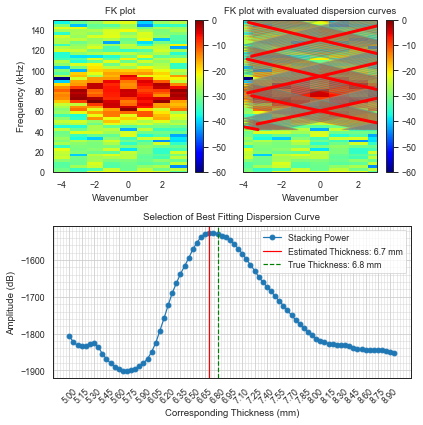

6.7

In [91]:
fk_c, k_array, f_array = make_fk(X_sample_n_crop[42,:,:].T, dt, make_dtheta(1))
#fk = np.abs(fk_c)
fk = 20*np.log10(np.abs(fk_c)/np.max(np.abs(fk_c)))
FK_thickness_estimation(fk, k_array, f_array, make_dtheta(1), steel.vp_antisym['A0'], ds, 40e3, 150e3, angular=True, circumference=circ, d_true=6.8, db=True)

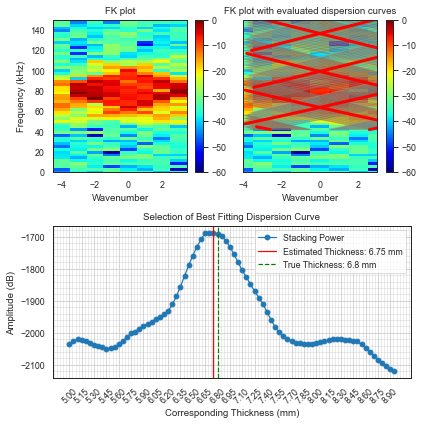

6.75

In [92]:
fk_c, k_array, f_array = make_fk(verasonics_data.T, dt, make_dtheta(1))
#fk = np.abs(fk_c)
fk = 20*np.log10(np.abs(fk_c)/np.max(np.abs(fk_c)))
FK_thickness_estimation(fk, k_array, f_array, make_dtheta(1), steel.vp_antisym['A0'], ds, 40e3, 150e3, angular=True, circumference=circ, d_true=6.8, db=True, circ_correction=True)

In [93]:
len(verasonics_data), X_sample_n_crop[42,:,:].shape[0]

(8, 8)

In [94]:
spect_v = np.zeros(len(verasonics_data))

In [95]:
spect_v.shape

(8,)

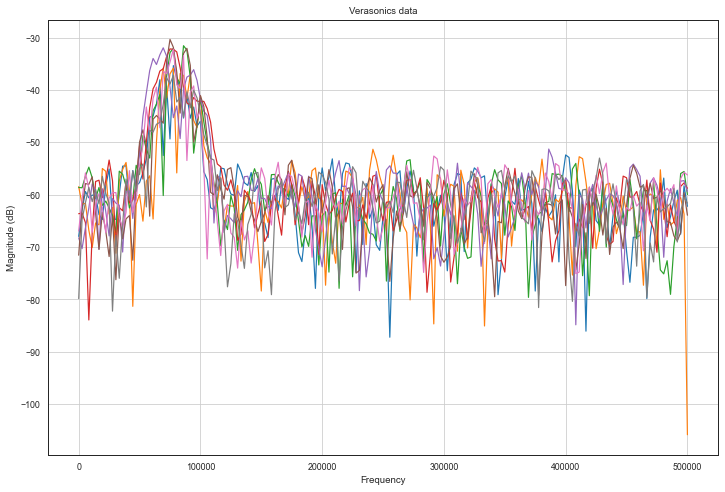

In [96]:
spect_v = list()
freqs_v = list()
segments_v = list()
plt.figure(figsize=(12,8))
plt.title('Verasonics data')
plt.grid()
for i in range(len(verasonics_data)):
    
    spect_v_temp, freqs_v_temp, line = plt.magnitude_spectrum(verasonics_data[i], Fs=1e6, scale='dB')
    spect_v.append(spect_v_temp)
    freqs_v.append(freqs_v_temp)
    segments_v.append(np.column_stack([freqs_v_temp, 20*np.log10(spect_v_temp)]))


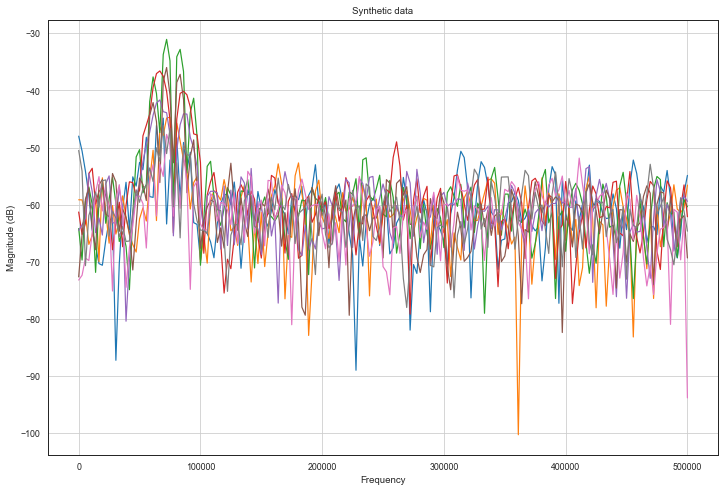

In [97]:
spect_s = list()
freqs_s = list()
segments_s = list()
plt.figure(figsize=(12,8))
plt.title('Synthetic data')
plt.grid()
for i in range(X_sample_n_crop[42,:,:].shape[0]):
    spect_s_temp, freqs_s_temp, line = plt.magnitude_spectrum(X_sample_n_crop[42,i,:], Fs=1e6, scale='dB')
    spect_s.append(spect_s_temp)
    freqs_s.append(freqs_s_temp)
    segments_s.append(np.column_stack([freqs_s_temp, 20*np.log10(spect_s_temp)]))

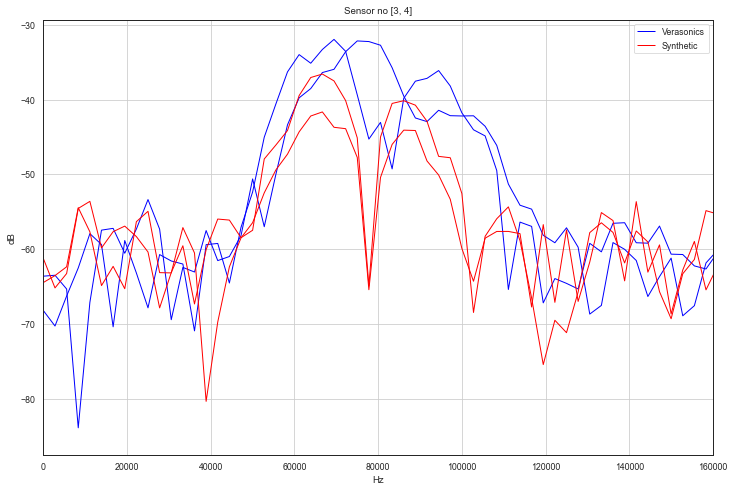

In [98]:

s = 3
indeces = [0+s, 7-s]
line_collection_v = LineCollection(list(map(lambda x: segments_v[x], indeces)), colors='blue', linewidths=1, label='Verasonics')
line_collection_s = LineCollection(list(map(lambda x: segments_s[x], indeces)), colors='red', linewidths=1, label='Synthetic')
fig, ax = plt.subplots(figsize=(12, 8))
ax.add_collection(line_collection_v)
ax.add_collection(line_collection_s)
ax.autoscale()
ax.set_xlim(0, 160e3)
ax.set_xlabel('Hz')
ax.set_ylabel('dB')
#ax.set_yscale('log')
#ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)} dB"))
plt.legend()
plt.title(f'Sensor no {indeces}')
plt.grid()
plt.show()

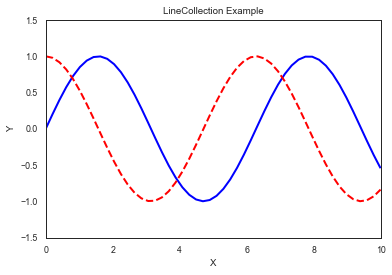

In [99]:
# Create some sample data
x = np.linspace(0, 10, 50)
y1 = np.sin(x)
y2 = np.cos(x)

# Create line segments from data
segments1 = np.column_stack([x, y1])
segments2 = np.column_stack([x, y2])

# Create a LineCollection from the line segments
segments = [segments1, segments2]
line_collection = LineCollection(segments, colors=['blue', 'red'], linestyles=['solid', 'dashed'], linewidths=2)

# Create a figure and axis
fig, ax = plt.subplots()

# Add the LineCollection to the axis
ax.add_collection(line_collection)

# Set plot limits and labels
ax.set_xlim(0, 10)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('LineCollection Example')

# Show the plot
plt.show()

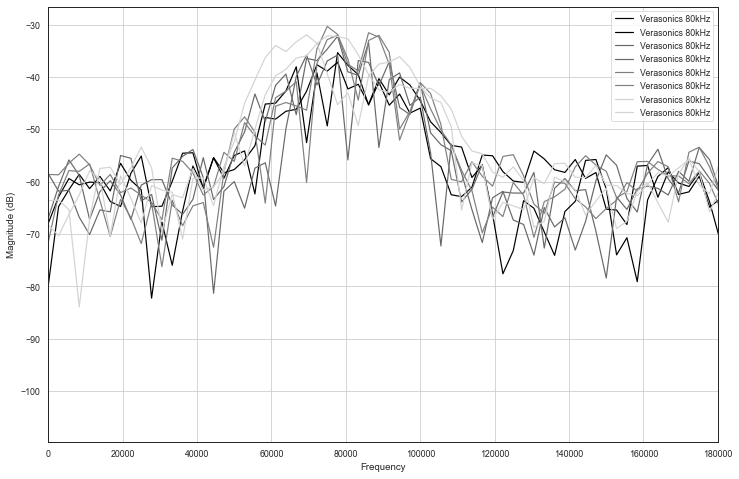

In [100]:
plt.figure(figsize=(12,8))
plt.magnitude_spectrum(verasonics_data[0], Fs=1e6, scale='dB', label='Verasonics 80kHz', color='black', ls='-')
plt.magnitude_spectrum(verasonics_data[7], Fs=1e6, scale='dB', label='Verasonics 80kHz', color='black', ls='-')
plt.magnitude_spectrum(verasonics_data[1], Fs=1e6, scale='dB', label='Verasonics 80kHz', color='dimgray', ls='-')
plt.magnitude_spectrum(verasonics_data[6], Fs=1e6, scale='dB', label='Verasonics 80kHz', color='dimgray', ls='-')
plt.magnitude_spectrum(verasonics_data[2], Fs=1e6, scale='dB', label='Verasonics 80kHz', color='gray', ls='-')
plt.magnitude_spectrum(verasonics_data[5], Fs=1e6, scale='dB', label='Verasonics 80kHz', color='gray', ls='-')
plt.magnitude_spectrum(verasonics_data[3], Fs=1e6, scale='dB', label='Verasonics 80kHz', color='lightgray', ls='-')
plt.magnitude_spectrum(verasonics_data[4], Fs=1e6, scale='dB', label='Verasonics 80kHz', color='lightgray', ls='-')
#plt.magnitude_spectrum(X_sample_n_crop[168,1,:], Fs=1e6, scale='dB', label='Simulated')
plt.xlim(0, 180e3)
plt.grid()
plt.legend()
plt.show()

# Machine Learning

In [101]:
x_train, x_test, y_train, y_test = train_test_split(X_sample_n_crop, X_sample_c_crop, test_size=0.2, random_state=42)

In [102]:
def make_fk_samples(X, dt, dx, fk_minfreq=40e3, fk_maxfreq=120e3, returncomplex=False, returndb=False):
  X_fk = np.zeros(shape=X.shape)
  X_fk = np.swapaxes(X_fk, 2, 3)
  X_fk = np.expand_dims(X_fk, 2)
  X_fk = np.repeat(X_fk, 2, axis=2)
  print(X_fk.shape)
  for i in range(X_fk.shape[0]):
    for j in range(X_fk.shape[1]):
      if returncomplex:
        fk_temp, x_array, f_array = make_fk(X[i,j,:,:].T, dt, dx)
        fk_temp_real = np.real(fk_temp)
        fk_temp_im = np.imag(fk_temp)
        X_fk[i,j,0,:,:] = fk_temp_real/400
        X_fk[i,j,1,:,:] = fk_temp_im/400

      else:
        fk_temp, x_array, f_array = make_fk(X[i,j,:,:].T, dt, dx)
        fk_temp_amp = np.abs(fk_temp)#/np.max(np.abs(fk_temp))
        if returndb:
          fk_temp_amp = 20*np.log10(fk_temp_amp)
        fk_temp_amp = minmax_scale(fk_temp_amp)
        fk_temp_angle = np.unwrap(np.angle(fk_temp))
        fk_temp_angle = minmax_scale(fk_temp_angle)
        X_fk[i,j,0,:,:] = fk_temp_amp
        X_fk[i,j,1,:,:] = fk_temp_angle



  #fk_maxfreq = 120e3
  fk_f_indeces = np.where((f_array >= fk_minfreq) & (f_array <= fk_maxfreq))

  f_array = f_array[fk_f_indeces[0]]
  X_fk = X_fk[:,:,:,fk_f_indeces[0],:]

  return X_fk, x_array, f_array

In [103]:
X_sample_n_crop = np.expand_dims(X_sample_n_crop, 1)
X_sample_c_crop = np.expand_dims(X_sample_c_crop, 1)

In [104]:
dt

1e-06

In [105]:
X_sample_n_fk, x_array, f_array = make_fk_samples(X_sample_n_crop, dt, make_dx(1), returndb=False)
X_sample_c_fk, x_array, f_array = make_fk_samples(X_sample_c_crop, dt, make_dx(1), returndb=False)

(9383, 1, 2, 360, 8)
(9383, 1, 2, 360, 8)


In [106]:
amp_only = True
if amp_only:
  X_sample_n_fk = X_sample_n_fk[:,:,0,:,:]
  X_sample_c_fk = X_sample_c_fk[:,:,0,:,:]

In [107]:
X_sample_n_fk.shape, X_sample_c_fk.shape

((9383, 1, 29, 8), (9383, 1, 29, 8))

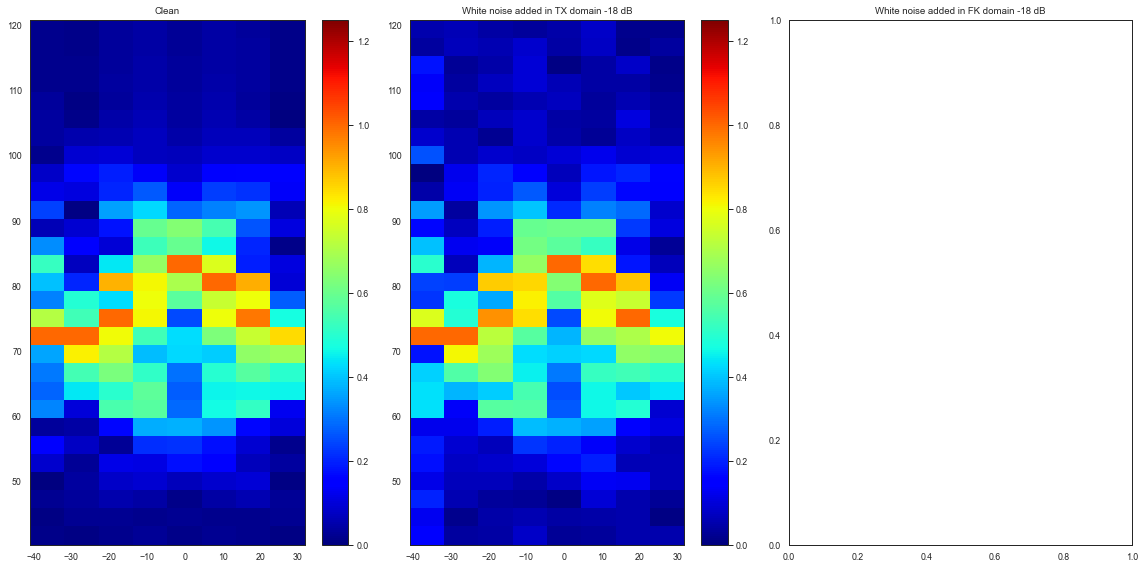

In [108]:
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.pcolormesh(x_array, f_array/1e3, X_sample_c_fk[230,0,:,:], cmap='jet', vmin=0, vmax=1.25)
plt.colorbar()
plt.title('Clean')
plt.subplot(1,3,2)
plt.pcolormesh(x_array, f_array/1e3, X_sample_n_fk[230,0,:,:], cmap='jet', vmin=0, vmax=1.25)
plt.colorbar()
plt.title(f'White noise added in TX domain {noisedb} dB')
plt.subplot(1,3,3)
#plt.pcolormesh(x_array, f_array/1e3, X_sample_c_n_fk[230,0,:,:], cmap='jet', vmin=0, vmax=1.25)
#plt.colorbar()
plt.title(f'White noise added in FK domain {noisedb} dB')
plt.tight_layout()
plt.show()

In [109]:
x_train_fk, x_test_fk, y_train_fk, y_test_fk = train_test_split(X_sample_n_fk, X_sample_c_fk, test_size=0.2, random_state=42)

In [110]:
x_train_flat_fk = x_train_fk.reshape((len(x_train_fk), np.prod(x_train_fk.shape[1:])))
x_test_flat_fk = x_test_fk.reshape((len(x_test_fk), np.prod(x_test_fk.shape[1:])))
y_train_flat_fk = y_train_fk.reshape((len(y_train_fk), np.prod(y_train_fk.shape[1:])))
y_test_flat_fk = y_test_fk.reshape((len(y_test_fk), np.prod(y_test_fk.shape[1:])))

In [111]:
x_train_flat_fk.shape, x_test_flat_fk.shape, y_train_flat_fk.shape, y_test_flat_fk.shape

((7506, 232), (1877, 232), (7506, 232), (1877, 232))

In [112]:
attributes = ['Thickness mean','Thickness minimum', 'Thickness std', 'Depression depth', 'Depression width','Pitting depth']

## Direct regression in FK

Thickness mean
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


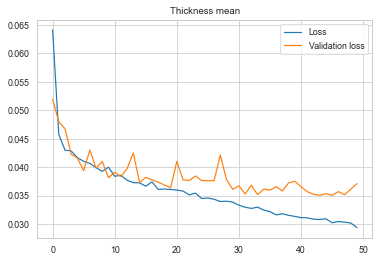

59/59 [==============================] - 0s 1ms/step - loss: 0.0371
loss: 0.03714613616466522
Thickness minimum
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


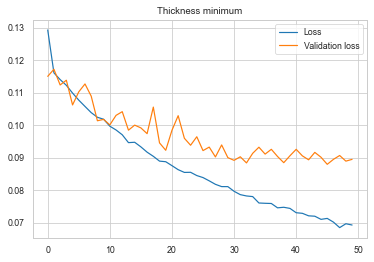

59/59 [==============================] - 0s 1ms/step - loss: 0.0895
loss: 0.08947765082120895
Thickness std
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


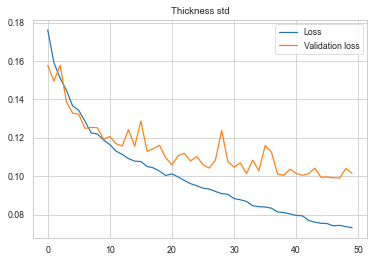

59/59 [==============================] - 0s 2ms/step - loss: 0.1015
loss: 0.10152458399534225
Depression depth
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


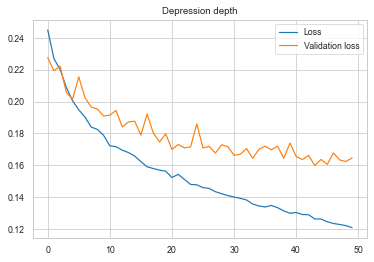

59/59 [==============================] - 0s 3ms/step - loss: 0.1646
loss: 0.1645973026752472
Depression width
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


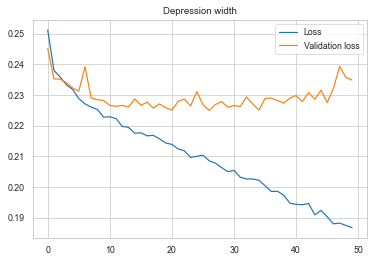

59/59 [==============================] - 0s 3ms/step - loss: 0.2348
loss: 0.23484550416469574
Pitting depth
Layer added; size: 32
Layer added; size: 16
Layer added; size: 8
Layer added; size: 4
Layer added; size: 2


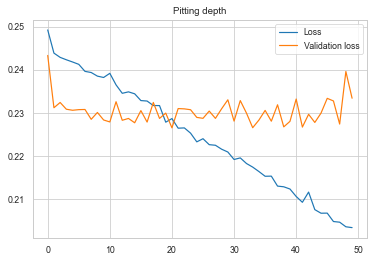

59/59 [==============================] - 0s 1ms/step - loss: 0.2334
loss: 0.23339621722698212


In [113]:
df_loss, df_test, df_predict, direct_regression_models_fk, min_max_scalers = do_regression(X_sample_n_fk, labels, attributes)

In [114]:
scales = np.array([[4.5, 8.5],
                   [-0.5, 8.5],
                   [0, 1.8],
                   [-0.5, 5.5],
                   [150, 550],
                   [0, 2.25]])
scales = np.array([[4.5, 11.0],
                   [-0.5, 11.0],
                   [0, 1.8],
                   [-0.5, 5.5],
                   [0, 100],
                   [0, 2.25]])
df_scales = pd.DataFrame(scales.T, columns=df_test.columns)

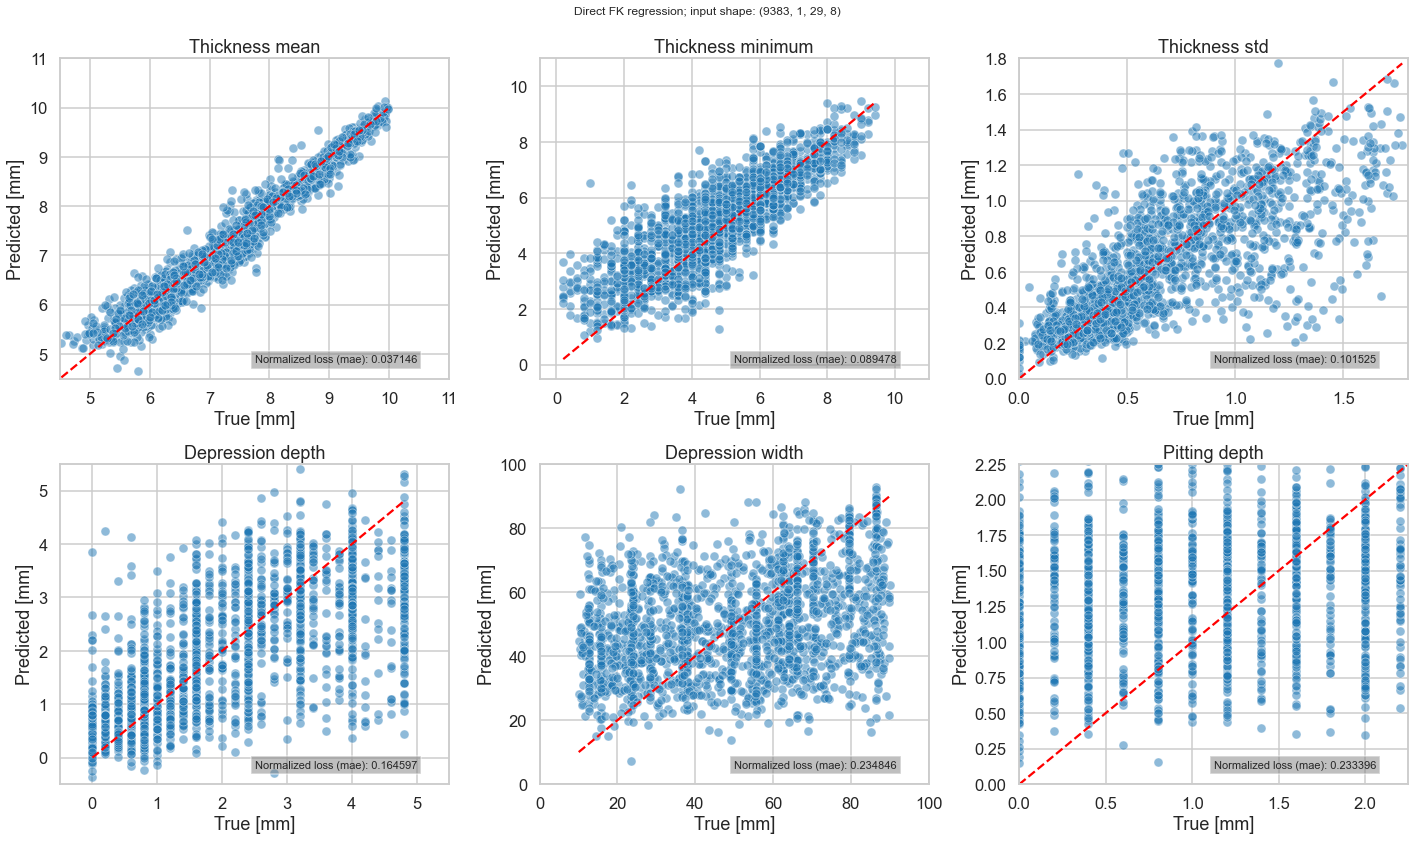

In [115]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='Direct FK regression; input shape: '+ str(X_sample_n_fk.shape))

In [116]:
#stop

## Direct Regression on Verasonics data

## Autoencoder in FK

Epoch 1/100


30/30 [==============================] - 1s 8ms/step - loss: 0.0850 - val_loss: 0.0376
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0259 - val_loss: 0.0212
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0205 - val_loss: 0.0202
Epoch 4/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0196 - val_loss: 0.0190
Epoch 5/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0180 - val_loss: 0.0171
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0163 - val_loss: 0.0158
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0153 - val_loss: 0.0149
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0143 - val_loss: 0.0140
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 0.0136 - val_loss: 0.0134
Epoch 10/100
30/30 [==============================] - 0s 6ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 11/100
30/30 [=

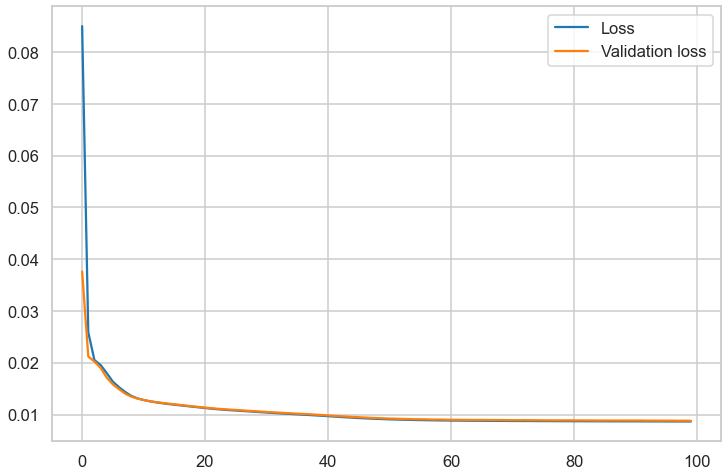

In [117]:
autoencoder_fk, encoder_fk = make_autoencoder(input_dim=x_train_flat_fk.shape[1], encoding_dim=16, activation='relu') #was 24
autoencoder_fk.compile(optimizer='adam', loss='mse')

history = autoencoder_fk.fit(x_train_flat_fk, y_train_flat_fk,
              epochs=100,
              batch_size=256,
              shuffle=True,
              validation_data=(x_test_flat_fk, y_test_flat_fk))

  #sns.set_style('whitegrid')
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Loss', 'Validation loss'])
plt.show()

In [118]:
decoded_traces_fk = autoencoder_fk.predict(x_test_flat_fk)
encoded_traces_fk = encoder_fk.predict(x_test_flat_fk)

 1/59 [..............................] - ETA: 4s

59/59 [==============================] - 0s 1ms/step


In [119]:
decoded_shaped_fk = decoded_traces_fk.reshape(len(decoded_traces_fk), y_test_fk.shape[1], y_test_fk.shape[2], y_test_fk.shape[3])

In [120]:
decoded_shaped_fk.shape, x_test_fk.shape

((1877, 1, 29, 8), (1877, 1, 29, 8))

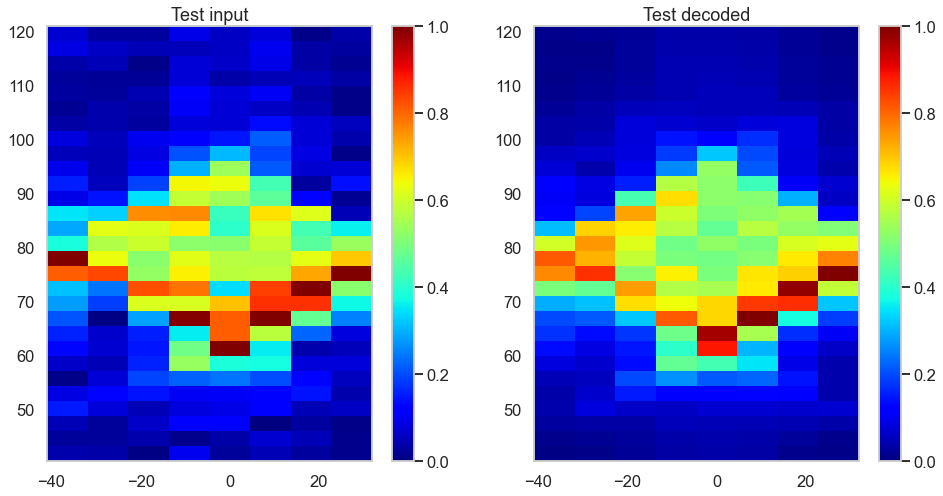

In [121]:
plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.pcolormesh(x_array, f_array/1e3, x_test_fk[0, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
plt.colorbar()
plt.title('Test input')

plt.subplot(1, 2, 2)
plt.pcolormesh(x_array, f_array/1e3, decoded_shaped_fk[0, 0,:, :], cmap='jet', vmin=0, vmax=1)
#plt.grid()
plt.colorbar()
plt.title('Test decoded')



plt.show()

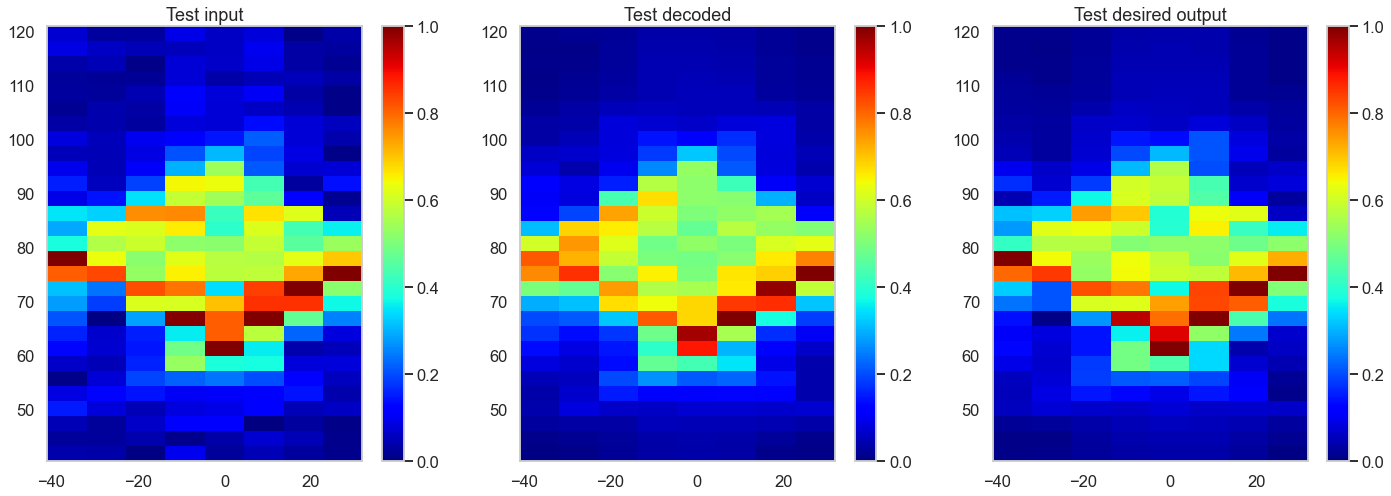

In [122]:
#sampleno = 3
for sampleno in range(0,1):
  plt.figure(figsize=(24,8))

  plt.subplot(1, 3, 1)
  plt.pcolormesh(x_array, f_array/1e3, x_test_fk[sampleno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Test input')

  plt.subplot(1, 3, 2)
  plt.pcolormesh(x_array, f_array/1e3, decoded_shaped_fk[sampleno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Test decoded')

  plt.subplot(1, 3, 3)
  plt.pcolormesh(x_array, f_array/1e3, y_test_fk[sampleno, 0,:, :], cmap='jet', vmin=0, vmax=1)
  #plt.grid()
  plt.colorbar()
  plt.title('Test desired output')


  #plt.savefig('./images/simulations_autoencoder_' + str(sampleno).zfill(2) + '.png')
  plt.show()

In [123]:
X_sample_flat_fk = X_sample_n_fk.reshape((len(X_sample_n_fk), np.prod(X_sample_n_fk.shape[1:])))
X_sample_flat_fk.shape

(9383, 232)

In [124]:
encoded_all_fk = encoder_fk.predict(X_sample_flat_fk)

132/294 [============>.................] - ETA: 0s

294/294 [==============================] - 0s 1ms/step


Thickness mean
Layer added; size: 4
Layer added; size: 2


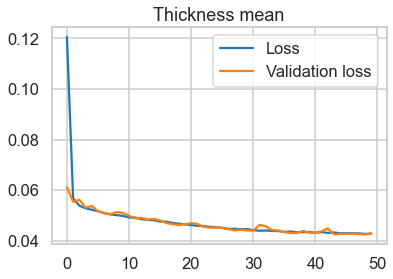

59/59 [==============================] - 0s 974us/step - loss: 0.0429
loss: 0.04286831617355347
Thickness minimum
Layer added; size: 4
Layer added; size: 2


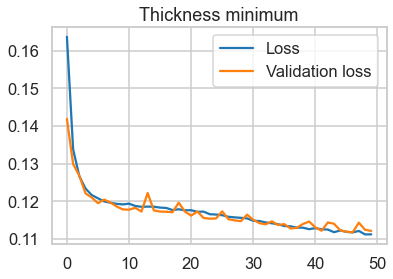

59/59 [==============================] - 0s 1ms/step - loss: 0.1122
loss: 0.11215034127235413
Thickness std
Layer added; size: 4
Layer added; size: 2


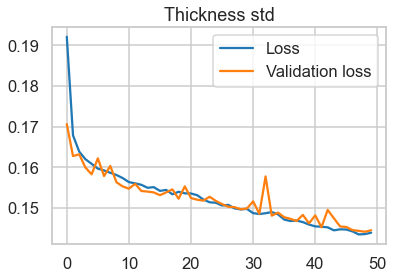

59/59 [==============================] - 0s 1ms/step - loss: 0.1444
loss: 0.14443832635879517
Depression depth
Layer added; size: 4
Layer added; size: 2


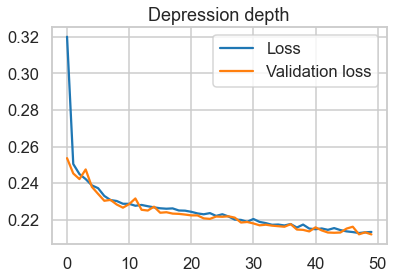

59/59 [==============================] - 0s 2ms/step - loss: 0.2119
loss: 0.2119097262620926
Depression width
Layer added; size: 4
Layer added; size: 2


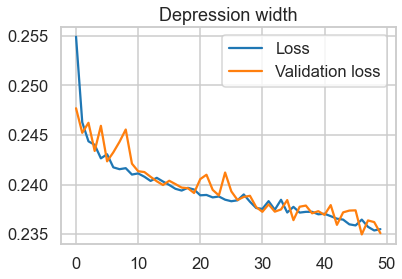

59/59 [==============================] - 0s 1ms/step - loss: 0.2351
loss: 0.2350907176733017
Pitting depth
Layer added; size: 4
Layer added; size: 2


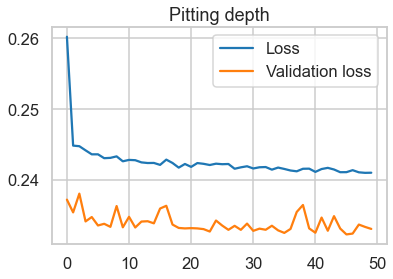

59/59 [==============================] - 0s 2ms/step - loss: 0.2331
loss: 0.23311060667037964


In [125]:
df_loss, df_test, df_predict, autoencoder_regression_models_fk, min_max_scalers = do_regression(encoded_all_fk, labels, attributes)

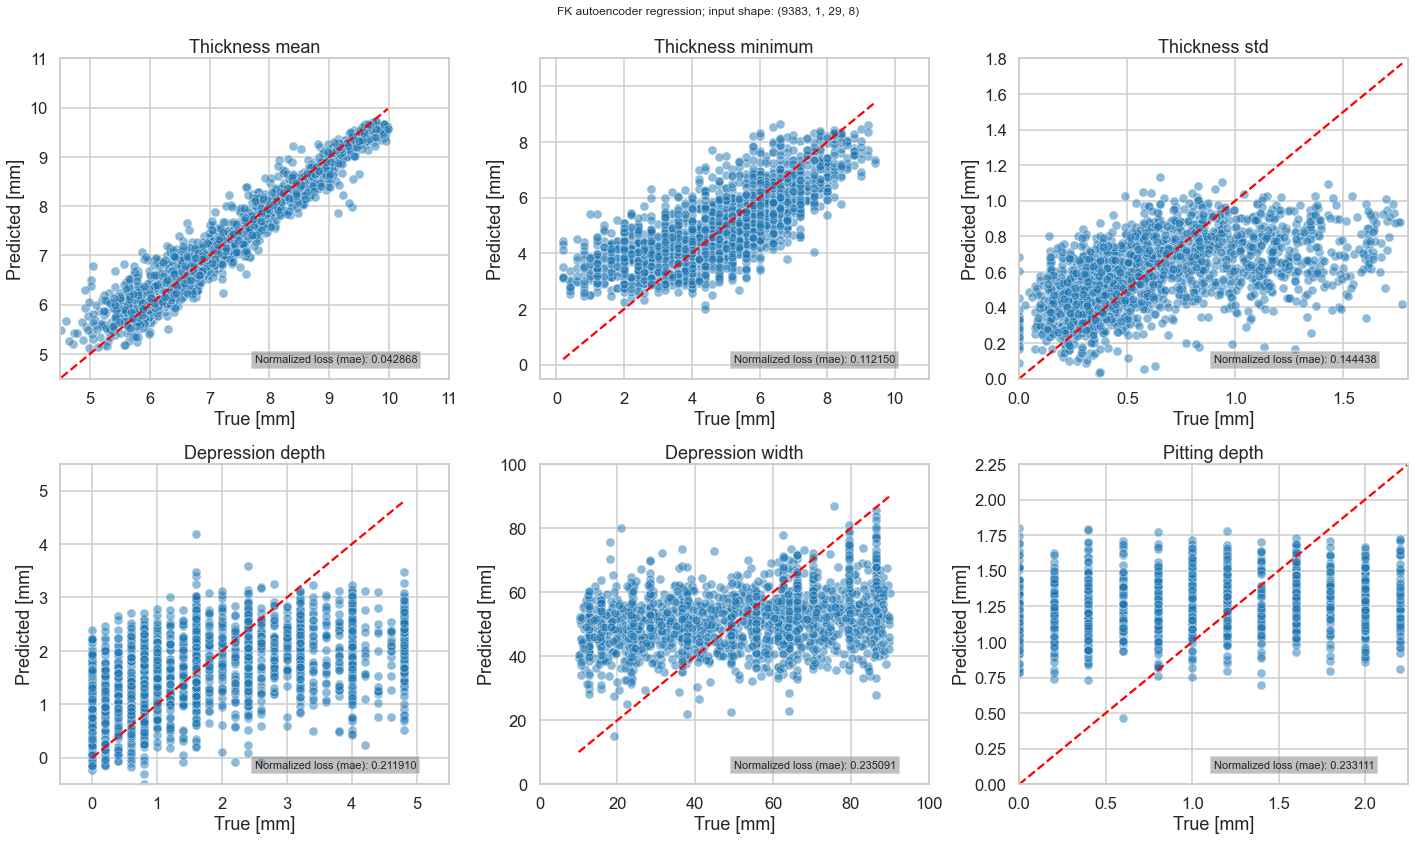

In [126]:
plot_reg_results(df_test, df_predict, df_loss, df_scales, perc=False, title='FK autoencoder regression; input shape: '+ str(X_sample_n_fk.shape))

In [127]:
def decode_sample(autoencoder, sample):
  sample_flat = sample.reshape(np.prod(sample.shape))
  sample_flat = np.expand_dims(sample_flat, axis=0)
  decoded_sample = autoencoder.predict(sample_flat)
  decoded_sample_shaped = decoded_sample.reshape(sample.shape)
  return decoded_sample_shaped

In [128]:
verasonics_data_expanded = np.expand_dims(verasonics_data, [0, 1])

In [129]:
verasonics_data_expanded.shape

(1, 1, 8, 360)

In [130]:
verasonics_fk, verasonics_x_array, verasonics_f_array = make_fk_samples(verasonics_data_expanded, dt, make_dx(1), returndb=False)

(1, 1, 2, 360, 8)


In [131]:
verasonics_fk.shape

(1, 1, 2, 29, 8)

In [132]:
verasonics_fk = verasonics_fk[:,:,0,:,:]

In [133]:
verasonics_fk.shape

(1, 1, 29, 8)

In [134]:
decoded_measurement_fk = decode_sample(autoencoder_fk, verasonics_fk)

1/1 [==============================] - 0s 26ms/step


In [135]:
decoded_measurement_fk.shape

(1, 1, 29, 8)

1/1 [==============================] - 0s 24ms/step


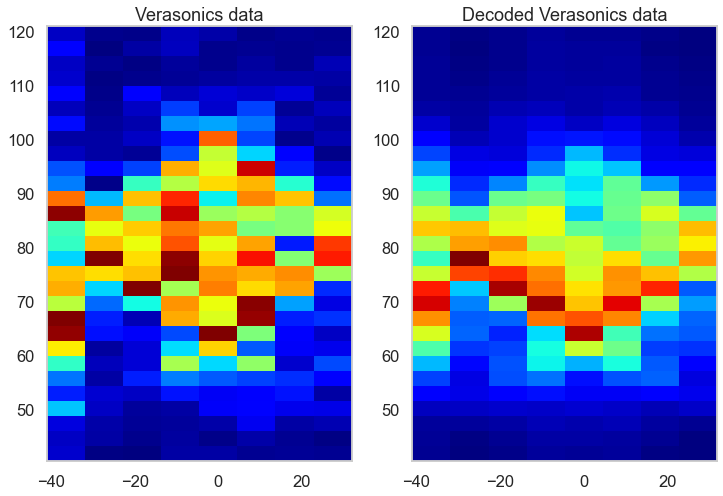

In [136]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.pcolormesh(verasonics_x_array, verasonics_f_array/1e3, verasonics_fk[0,0,:,:], cmap='jet')
plt.title('Verasonics data')
plt.subplot(1,2,2)
plt.pcolormesh(verasonics_x_array, verasonics_f_array/1e3, decode_sample(autoencoder_fk, verasonics_fk)[0,0,:,:], cmap='jet')
plt.title('Decoded Verasonics data')
plt.show()

### Conventional thickness estimation on decoded verasonics dataset

1/1 [==============================] - 0s 32ms/step


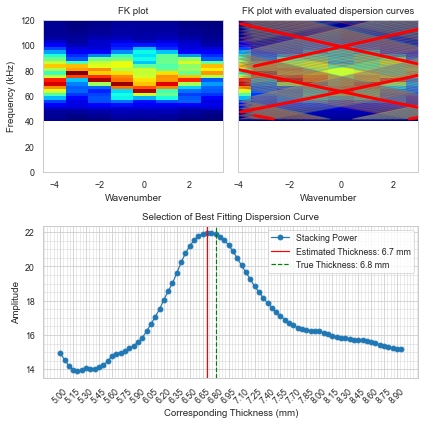

6.7

In [137]:
sns.set_context('paper')
FK_thickness_estimation(decode_sample(autoencoder_fk, verasonics_fk)[0,0,:,:], k_array, verasonics_f_array, make_dtheta(1), steel.vp_antisym['A0'], ds, 40e3, 120e3, angular=True, circumference=circ, d_true=6.8, db=False, circ_correction=True)

### Regression on encodings

In [138]:
measurements_flat_fk = verasonics_fk.reshape((len(verasonics_fk), np.prod(verasonics_fk.shape[1:])))

In [139]:
encoded_measurements_fk = encoder_fk.predict(measurements_flat_fk)

1/1 [==============================] - 0s 25ms/step


In [140]:
real_prediction = {}
for i, attribute in enumerate(attributes):
    real_prediction_norm = autoencoder_regression_models_fk[attribute](encoded_measurements_fk)
    real_prediction[attribute] = min_max_scalers[attribute].inverse_transform(real_prediction_norm)

In [141]:
real_prediction

{'Thickness mean': array([[7.29117551]]),
 'Thickness minimum': array([[4.26599085]]),
 'Thickness std': array([[0.82891515]]),
 'Depression depth': array([[1.93881097]]),
 'Depression width': array([[53.10741588]]),
 'Pitting depth': array([[1.03393297]])}

### Direct Regression on Verasonics Data

In [142]:
real_prediction_direct_regression = {}
for i, attribute in enumerate(attributes):
    real_prediction_direct_regression_norm = direct_regression_models_fk[attribute](measurements_flat_fk)
    real_prediction_direct_regression[attribute] = min_max_scalers[attribute].inverse_transform(real_prediction_direct_regression_norm)

In [143]:
real_prediction_direct_regression

{'Thickness mean': array([[7.21496052]]),
 'Thickness minimum': array([[5.4816215]]),
 'Thickness std': array([[0.28426592]]),
 'Depression depth': array([[2.34686823]]),
 'Depression width': array([[17.6831192]]),
 'Pitting depth': array([[0.38328786]])}